In [73]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pathlib import Path

In [74]:
ROOT = Path.cwd().resolve().parent
DATA = ROOT / "Data" 
CSV  = DATA / "data_for_year"

In [75]:
years = [2021, 2022, 2023, 2024]

dfs = {
    year: pd.read_csv(CSV / f"lifesat_gdp_{year}.csv")
    for year in years
}

In [76]:
def plot_lifesat_gdp(year,dfs):
    x = dfs[year][["GDP per capita, PPP (constant 2021 international $)"]].values 
    y = dfs[year][["Cantril ladder score"]].values
    dfs[year].plot(kind='scatter', grid=True, x="GDP per capita, PPP (constant 2021 international $)", y="Cantril ladder score") 
    plt.title(f"Life satisfaction vs GDP in {year}")
    plt.show() 

Let's see the form of the data

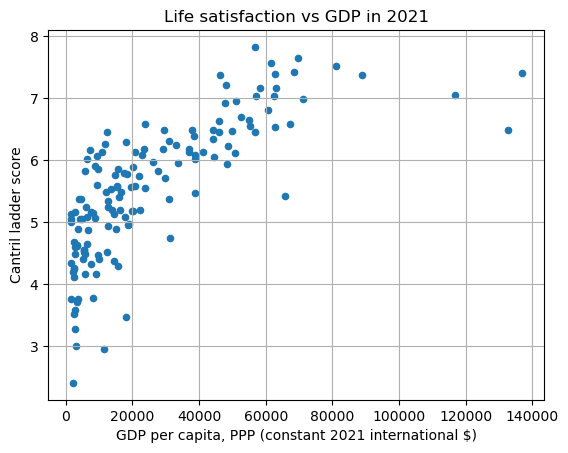

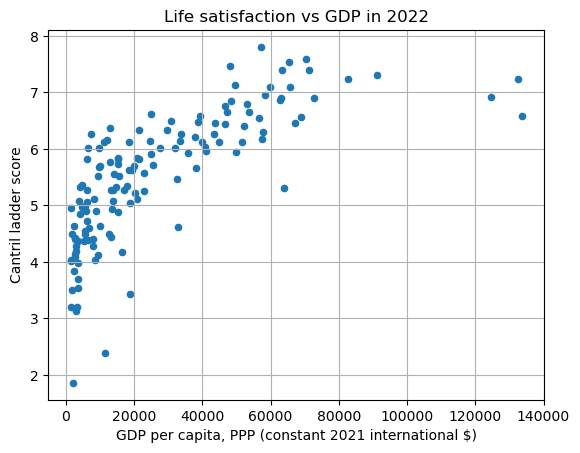

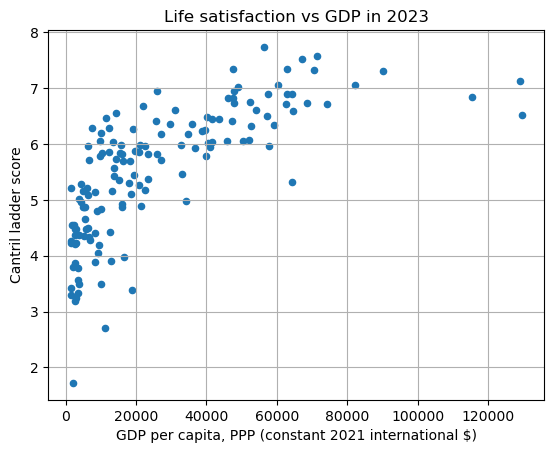

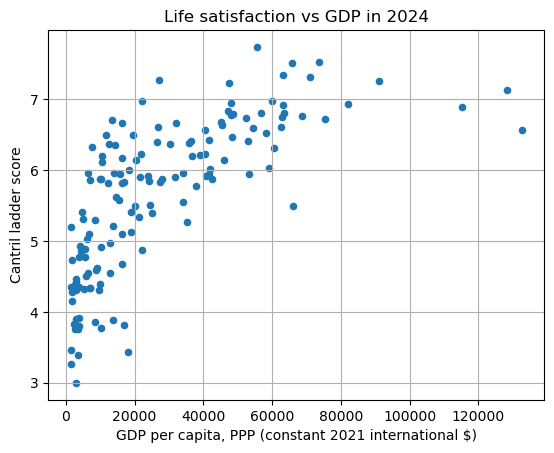

In [77]:
for year in years:
    plot_lifesat_gdp(year,dfs)

We can see that the best model for each of the years appears to be a logarithmic regression.

$$ \hat{y}(x) = \theta_0 + \theta_1 log(x)$$

In [78]:
from scipy.optimize import curve_fit

def plot_log(year, dfs):

    def log_func(x, theta_0, theta_1):
        return theta_0 + theta_1 * np.log(x)

    x = dfs[year]["GDP per capita, PPP (constant 2021 international $)"].values
    y = dfs[year]["Cantril ladder score"].values

    mask = (x > 0) & np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    params, _ = curve_fit(log_func, x, y)
    theta_0, theta_1 = params

    x_line = np.linspace(x.min(), x.max(), 500)

    plt.scatter(x, y)
    plt.plot(x_line, log_func(x_line, theta_0, theta_1),
        label=f"theta_0: {theta_0:.2f}, theta_1: {theta_1:.2f}",
        color="red")
    plt.legend()
    plt.xlabel("GDP per capita, PPP (constant 2021 international $)")
    plt.ylabel("Cantril ladder score")
    plt.title(f"Life satisfaction vs GDP in {year}")
    plt.show()

    return theta_0, theta_1


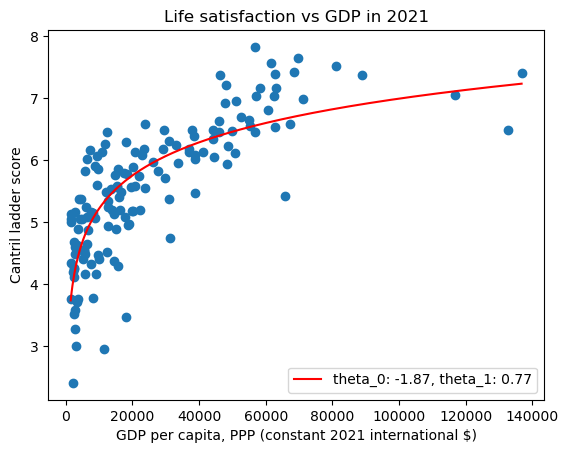

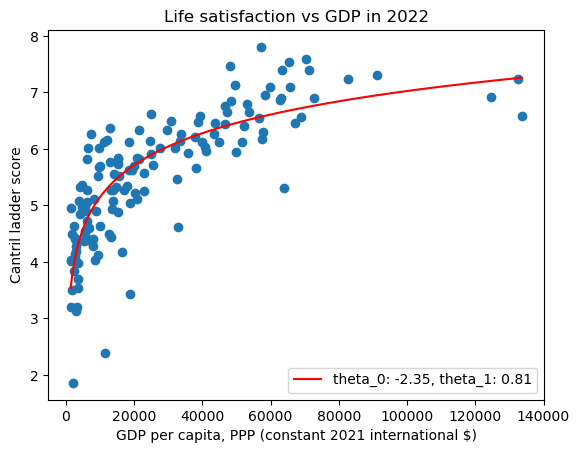

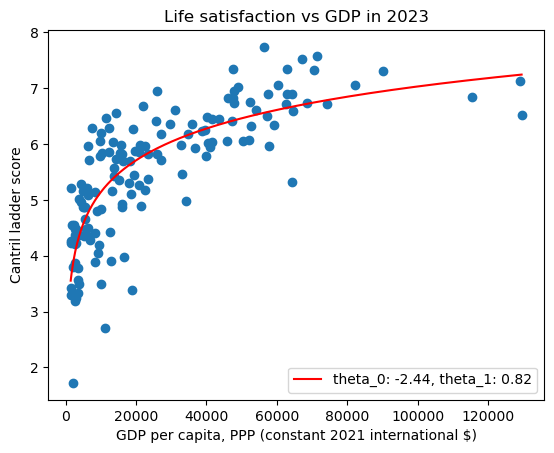

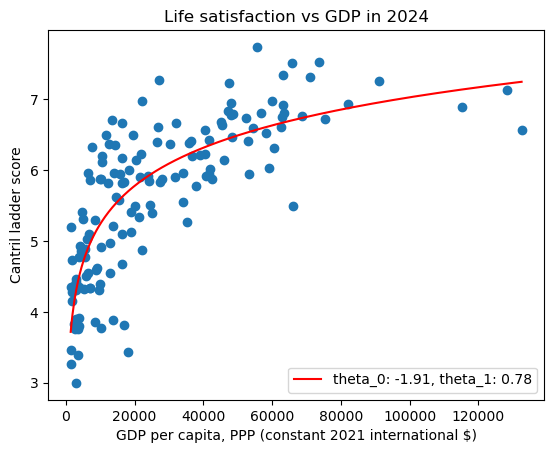

In [79]:
thetas = {}
for year in years:
    theta_0, theta_1 = plot_log(year,dfs)
    thetas[year] = (theta_0, theta_1)

Now we can predict some data.
For that we need some countries thar are not in the dfs.

In [80]:
GDP  = DATA / "gdp-per-capita-worldbank" / "gdp-per-capita-worldbank.csv"

In [81]:
df_gdp = pd.read_csv(GDP)
df_gdp = df_gdp[['Entity', 'Year', 'GDP per capita, PPP (constant 2021 international $)']]
df_gdp.dropna(inplace=True)

In [82]:
years = [2021, 2022, 2023, 2024]
gdps = {}
for year in years:
    gdps[year] = df_gdp[df_gdp["Year"] == year]

In [83]:
countries_outside_lifesat = {}
for year in years:
    countries_outside_lifesat[year] = gdps[year][~gdps[year]['Entity'].isin(dfs[year]['Entity'])]

In [84]:
for year in years:
    def log_func(x, theta_0, theta_1):
        return theta_0 + theta_1 * np.log(x)

    country = countries_outside_lifesat[year].iloc[0,0]
    gdp = countries_outside_lifesat[year].iloc[0,2]
    theta_0, theta_1 = thetas[year]

    lifesat = log_func(gdp, theta_0, theta_1)

    print(f"For the country {country} with gdp = {gdp:.2f} we have the value of life satisfaction of {lifesat:.2f} in {year}")

For the country Andorra with gdp = 59332.20 we have the value of life satisfaction of 6.59 in 2021
For the country Andorra with gdp = 63913.38 we have the value of life satisfaction of 6.66 in 2022
For the country Andorra with gdp = 64631.30 we have the value of life satisfaction of 6.67 in 2023
For the country Andorra with gdp = 65928.30 we have the value of life satisfaction of 6.70 in 2024
